In [1]:
def load_aws_credentials(profile_name):
    "Returns (access_key, secred_key) from ~/.aws/credentials for the given profile."
    import boto3
    ses = boto3.Session(profile_name=profile_name)
    creds = ses.get_credentials()
    return (creds.access_key, creds.secret_key)

In [2]:
import neuropythy as ny

ny.config['hcp_credentials'] = load_aws_credentials('hcp')

filename = '/home/jovyan/shared/HCP/115825/MNINonLinear/Results/tfMRI_MOVIE2_7T_PA/tfMRI_MOVIE2_7T_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
cii = ny.load(filename)
(lh_bold, rh_bold, subcortex_bold) = ny.hcp.cifti_split(cii)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
lh_bold.shape

(918, 59292)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

sid = 111312
sub = ny.hcp_subject(sid)
lh = sub.hemis['lh_LR59k']
rh = sub.hemis['rh_LR59k']
view_pos = np.array([0, 100.0, 0])
lh_mproj_front = ny.map_projection(chirality='lh', registration='fs_LR', center=view_pos, radius=np.pi/2)
lh_mproj_back = ny.map_projection(chirality='lh', registration='fs_LR', center=-view_pos, radius=np.pi/2)
rh_mproj_front = ny.map_projection(chirality='rh', registration='fs_LR', center=view_pos, radius=np.pi/2)
rh_mproj_back = ny.map_projection(chirality='rh', registration='fs_LR', center=-view_pos, radius=np.pi/2)
lh_fmap_front = ny.to_flatmap(lh_mproj_front, lh)
lh_fmap_back = ny.to_flatmap(lh_mproj_back, lh)
rh_fmap_front = ny.to_flatmap(rh_mproj_front, rh)
rh_fmap_back = ny.to_flatmap(rh_mproj_back, rh)

In [13]:
def sub_channel(lh_data, rh_data):
    (fig, axs) = plt.subplots(2, 2, figsize=(2,2), dpi=72*4)
    ny.cortex_plot(lh_fmap_front, axes=axs[0,0], color=lh_data[lh_fmap_front.labels], cmap='gray')
    ny.cortex_plot(lh_fmap_back, axes=axs[1,0], color=lh_data[lh_fmap_back.labels], cmap='gray')
    ny.cortex_plot(rh_fmap_front, axes=axs[0,1], color=rh_data[rh_fmap_front.labels], cmap='gray')
    ny.cortex_plot(rh_fmap_back, axes=axs[1,1], color=rh_data[rh_fmap_back.labels], cmap='gray')
    fig.subplots_adjust(0,0,1,1,0,0)
    for ax in axs.flatten():
        ax.axis('off')
    return fig

In [21]:
import os

# Scrape HCP folder for subject IDs. Outputs a list of subject IDs
subj_id = []
path = '/home/jovyan/shared/HCP/'
for dir in os.listdir(path):
    parts = dir.split('.')
    subj_id.append(parts[0])
    # using list comprehension + enumerate() to remove duplicated from list
subj_id = [i for n, i in enumerate(subj_id) if i not in subj_id[:n]]
print(subj_id)

['115825']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


shape of image matrix 0:  (576, 576)
shape of image matrix 1:  (576, 576)
shape of image matrix 2:  (576, 576)
Shape of the stacked matrix: (576, 576, 3)


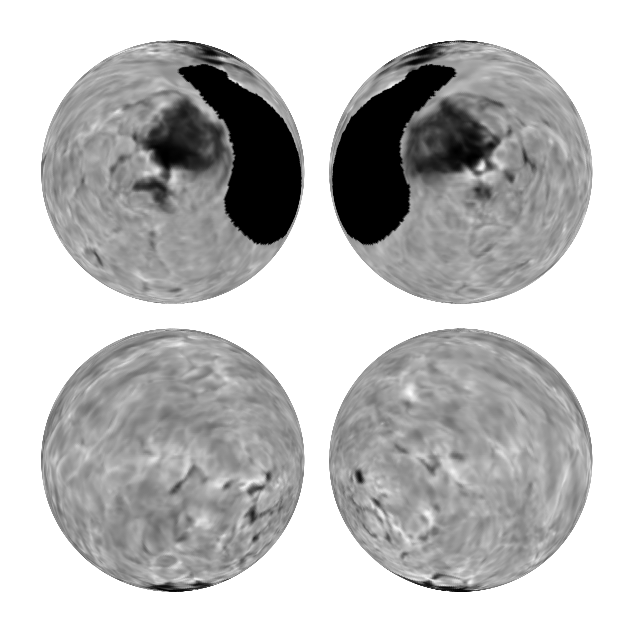

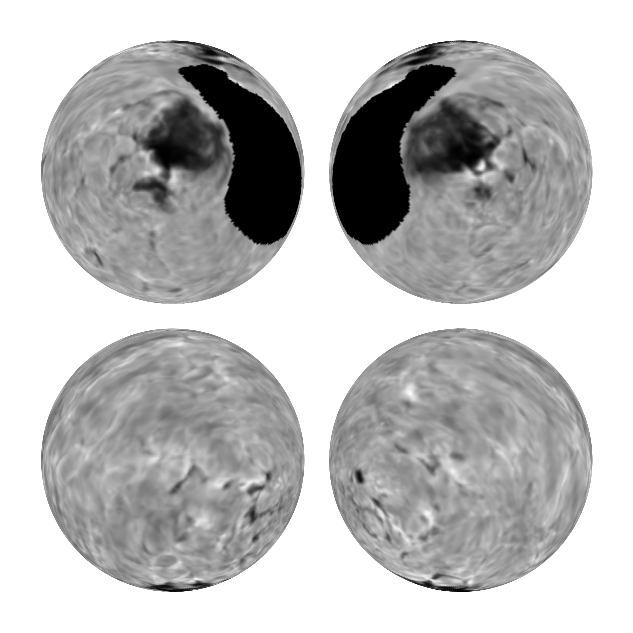

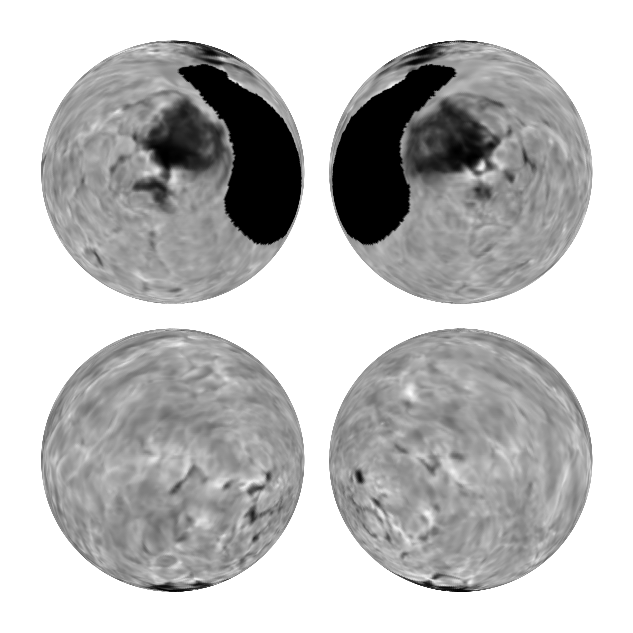

In [40]:
import skimage as sp
from PIL import Image

max_bold = 0
min_bold = 100
chunk_size = 5
img_matrices = []
for sid in subj_id:
    filename = path + sid + '/MNINonLinear/Results/tfMRI_MOVIE2_7T_PA/tfMRI_MOVIE2_7T_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
    cii = ny.load(filename)
    (lh_bold, rh_bold, subcortex_bold) = ny.hcp.cifti_split(cii)
#    if max(lh_bold, rh_bold) > max_bold:
#        max_bold = max(lh_bold, rh_bold)
#    if min(lh_bold, rh_bold) < min_bold:
#        min_bold = min(lh_bold, rh_bold)
    tr = lh_bold.shape[0]
    lh_bold_new = []
    rh_bold_new = []
    for i in range(0, tr, chunk_size): # averages over every 5 TRs
        lh_chunk = lh_bold[i:i+chunk_size, :]
        lh_chunk_mean = np.mean(lh_chunk, axis=0)
        lh_bold_new.append(lh_chunk_mean)
        rh_chunk = rh_bold[i:i+chunk_size, :]
        rh_chunk_mean = np.mean(rh_chunk, axis=0)
        rh_bold_new.append(rh_chunk_mean)
    for t in range(3):
        avg_img = sub_channel(lh_bold_new[t], rh_bold_new[t])
        plt.savefig(str(sid) + '_' + str(t) + '.png')
        # Open the RGBA image
        image_path = str(sid) + '_' + str(t) + '.png'
        rgba_image = Image.open(image_path)

        # Convert the RGBA image to grayscale
        grayscale_image = rgba_image.convert('L')

        # Save the grayscale image
        output_path = str(sid) + '_' + str(t) + '_gs.png'
        grayscale_image.save(output_path)
        
        im_mtx = sp.io.imread(output_path)
        print("shape of image matrix " + str(t) + ": ", im_mtx.shape)
        img_matrices.append(im_mtx)
        
stacked_matrix = np.stack(img_matrices, axis=2)
print("Shape of the stacked matrix:", stacked_matrix.shape)
#        ny.save.nifti(filename)
#        ny.load(image_array)

In [30]:
# Setting Training Hyperparameters
batch_size = 32  # original ResNet paper uses batch_size = 128 for training
epochs = 200
data_augmentation = True
num_classes = 10
  
# Data Preprocessing 
subtract_pixel_mean = True
n = 3
  
# Select ResNet Version
version = 1
  
# Computed depth of 
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
  
# Model name, depth and version
model_type = 'ResNet % dv % d' % (depth, version)
  
# Load the CIFAR-10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
  
# Input image dimensions.
input_shape = x_train.shape[1:]
  
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
  
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis = 0)
    x_train -= x_train_mean
    x_test -= x_train_mean
  
# Print Training and Test Samples 
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
  
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


   Syntax: surface_to_image <subject> <out>
   <subject> must be a valid FreeSurfer subject id (in the $SUBJECTS_DIR directory
     or configured subject paths) or a full path to a FreeSurfer subject or it can
     be a valid HCP subject identifier.
   <out> is the output volume file to write.
   In addition to the subject and the output filename, at least one and at most two
   surface file(s) must be specified. These may be specified using the --lh (or -l)
   and --rh (or -r) options below or without them; if they files are specified
   without the given arguments and the ordering cannot be detected by the number of
   vertices in the file, then the left hemisphere surface is assumed to be
   specified first.
   The command projects the given surface files into the subject's ribbon and
   writes the result out to the given filename. If only one hemisphere's surface
   datafile is given, then only that hemisphere's data is projected to the ribbon.

   The following options may be giv